# CNN Springfield

De los 49 posibles personajes escogí 13, porque son mis favoritos y porque si elegía más mi compu tardaba mucho y colab me cerraba la sesión.

Escogí a los siguientes 13 personajes: 

* Abuelo Simpson
* Apu
* Barney
* Jefe Gorgori
* Duff man
* Willie
* Homero
* Maggie
* Milhouse
* Flanders
* Nelson
* Otto
* Rafa

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

TRAINING_PATH = 'simpsons_dataset/'
TEST_PATH = 'simpsons_testdataset/'

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

2.5.0


# Leyendo y visualizando las imágenes

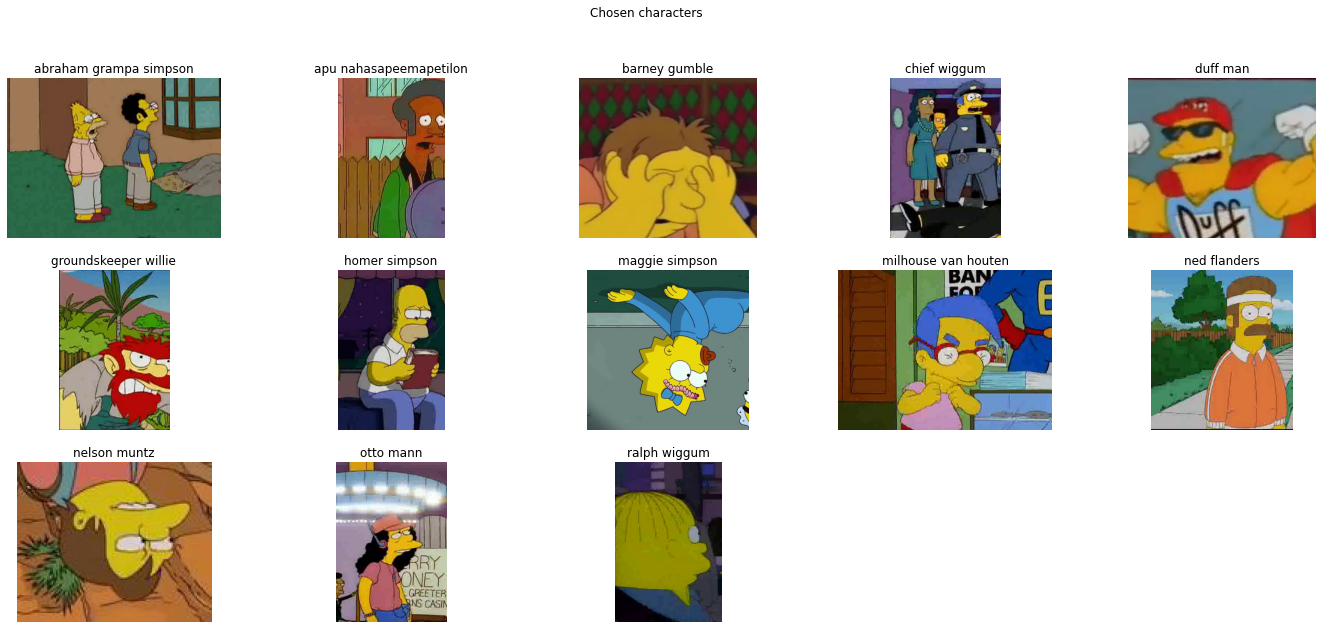

In [2]:
ROWS = 3
COLS = 5
path = 0
amount_images = np.zeros(len(paths))

fig, ax = plt.subplots(3, 5, figsize = (24, 10))
for i in range(ROWS):
    for j in range(COLS):
        pics = os.listdir(TRAINING_PATH + paths[path])
        amount_images[path] = len(pics)
        index = np.random.randint(len(pics))
        ax[i][j].imshow(Image.open(TRAINING_PATH + paths[path] + pics[index]))
        ax[i][j].axis('off')
        ax[i][j].set_title(' '.join(paths[path].split('_')).replace('/', ''))
        path += 1

        if (path > 12):
            break

fig.suptitle('Chosen characters')
ax[2][3].axis('off')
ax[2][4].axis('off')
plt.show()

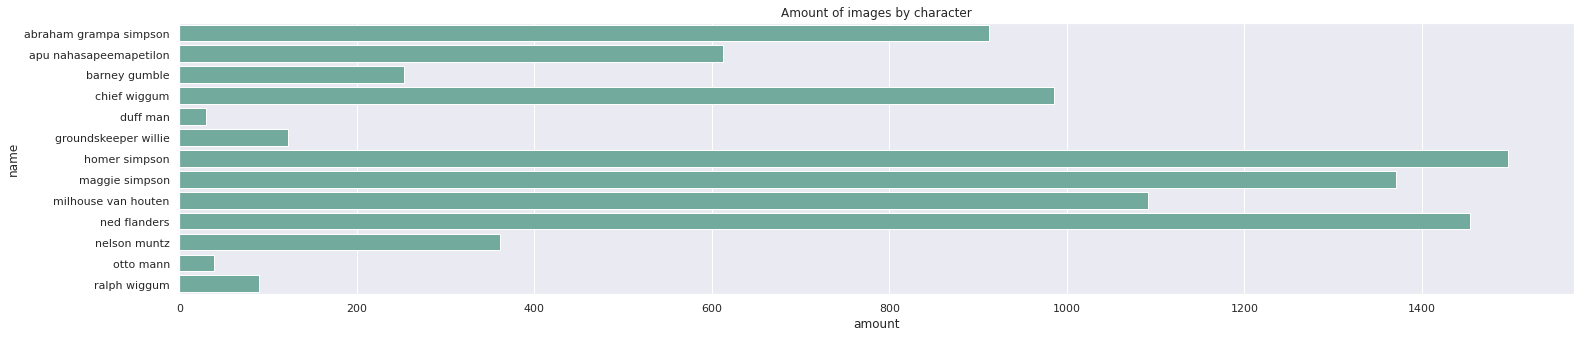

In [3]:
data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name',
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Aquí podemos observar que se trata, claramente, de un problema desbalanceado, homero tiene más de 4000 imágenes, mientras que personajes como Otto o Duff Man no llegan ni a 250 imágenes. En estos casos lo ideal es conseguir más imágenes de estos último o, en su defecto, deshacerse de algunas imágenes de las clases que tienen más imágenes, en este caso Homero. Homero tiene una gran cantidad de imágenes, por lo que las reduciremos a 1500 imágenes.

En caso de que se haya corrido otra vez el notebook aquí dejo una imagen de la gráfica antes de eliminar imágenes de Homero.

<img src="homero muchos.png">

Una cosa más que haremos es ver cuántos canales diferentes tienen las imágenes de las carpetas cuyos paths están contenidos en el arreglo *paths*.

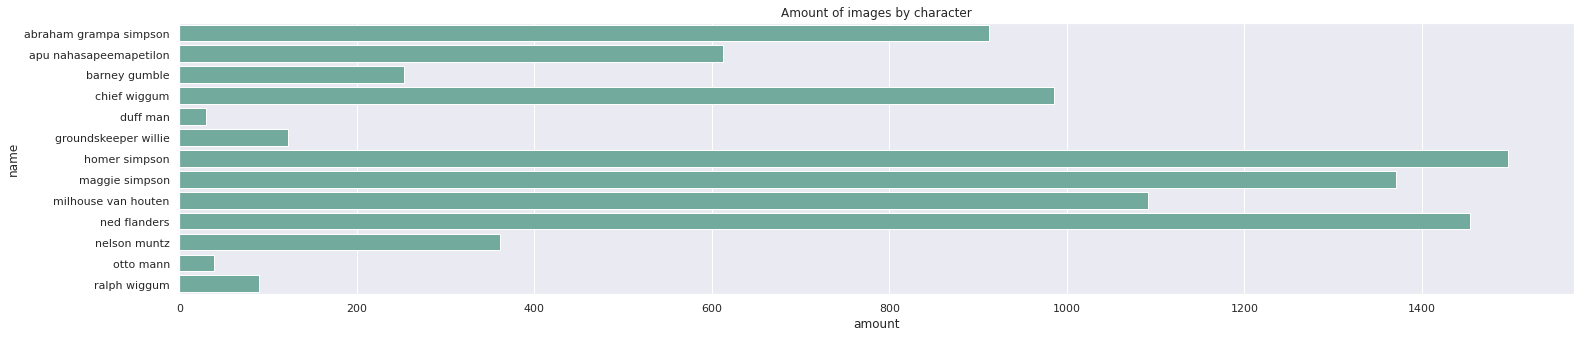

In [4]:
files = os.listdir(TRAINING_PATH + paths[6])
amount_delete = len(files) - 1497
files_to_delete = sample(files, amount_delete)

for fil in files_to_delete:
    os.remove(TRAINING_PATH + paths[6] + fil)

amount_images[6] = len(os.listdir(TRAINING_PATH + paths[6]))

data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name', 
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Ahora veremos las diferentes dimensiones que tienen las imágenes y los diferentes formatos

Para el conjunto de entrenamiento

In [5]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TRAINING_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TRAINING_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

        if (image_dim not in dimensions):
            dimensions.append(image_dim)
    
        if (extension not in extensions):
            extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3]
Different formats:  ['jpg', 'bmp']


Para el conjunto de prueba

In [6]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TEST_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TEST_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

        if (image_dim not in dimensions):
            dimensions.append(image_dim)
    
        if (extension not in extensions):
            extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3, 4]
Different formats:  ['jpg', 'png', 'JPG', 'jpeg']


# Leyendo el conjunto de datos y aplicando pre procesamiento

In [7]:
# Taken from
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [8]:
def load_image(filename, path,training = True):
    if (training):        
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TRAINING_PATH + path + filename)), tf.float32)[..., :3]/255            
  
    else:
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TEST_PATH + path + filename)), tf.float32)[..., :3]/255

    inimg = tf.image.resize(inimg, (32, 32))    
    inimg = rgb2gray(inimg)
    inimg = inimg[..., np.newaxis]

    return inimg

In [9]:
X_train = []
y_train = []

X_test = []
y_test = []

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

# Training
for i in range(len(paths)):

    files = os.listdir(TRAINING_PATH + paths[i])

    for j in range(len(files)):
        X_train.append(load_image(files[j], paths[i]))
        
    y_train.extend(np.full(len(files), i))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_train, y_train = shuffle(X_train, y_train)

# Testing
for i in range(len(paths)):

    files = os.listdir(TEST_PATH + paths[i])

    for j in range(len(files)):
        X_test.append(load_image(files[j], paths[i], training = False))
  
    y_test.extend(np.full(len(files), i))

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_test, y_test = shuffle(X_test, y_test)

onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

In [10]:
data = {'shapes': [np.asarray(inp).shape for inp in X_test]}

df = pd.DataFrame(data)
df.value_counts()

shapes     
(32, 32, 1)    942
dtype: int64

In [11]:
data = {'shapes': [np.asarray(inp).shape for inp in y_train_onehot]}

df = pd.DataFrame(data)
df.value_counts()

shapes
(13,)     8819
dtype: int64

In [12]:
data = {'shapes': [np.asarray(inp).shape for inp in y_test_onehot]}

df = pd.DataFrame(data)
df.value_counts()

shapes
(13,)     942
dtype: int64

In [91]:
class DNN_model(object):
    def __init__(self, n_classes=13):
        
        self.h1LW = tf.Variable(np.random.rand(7, 7, 1, 32) * 0.1,
                               name = 'hl1weights',
                               dtype = 'float32')
        
        self.h1LB = tf.Variable(np.random.rand(32) * 0.1,
                               name = 'hl1bias',
                               dtype = 'float32')
                
        self.h2LW = tf.Variable(np.random.rand(5, 5, 32, 32) * 0.1,
                               name = 'hl2weights',
                               dtype = 'float32')
        
        self.h2LB = tf.Variable(np.random.rand(32) * 0.1,
                               name = 'hl2bias',
                               dtype = 'float32')                
        
        self.h3LW = tf.Variable(np.random.rand(3, 3, 32, 16) * 0.1,
                               name = 'hl3weights',
                               dtype = 'float32')
        
        self.h3LB = tf.Variable(np.random.rand(16) * 0.1,
                               name = 'hl3bias',
                               dtype = 'float32')
        
        self.h4LW = tf.Variable(np.random.rand(16, 16) * 0.1,
                               name = 'hl4weights',
                               dtype = 'float32')
        
        self.h4LB = tf.Variable(np.random.rand(16) * 0.1,
                               name = 'hl4bias',
                               dtype = 'float32')                
        
        self.outW = tf.Variable(np.random.rand(16, n_classes) * 0.1,
                                name="outweigths",
                                dtype="float32")
        
        self.outB = tf.Variable(np.random.rand(n_classes) * 0.1,
                                name="outbias",
                                dtype="float32")
        
        self.trainable_variables =[self.h1LW,self.h1LB,
                                   self.h2LW,self.h2LB,
                                   self.h3LW,self.h3LB,
                                   self.h4LW,self.h4LB,
                                   self.outW,self.outB]
        
    def __call__(self,x):
        
        x  = tf.cast(x, tf.float32)
        img = tf.reshape(x, shape = [-1, 32, 32, 1])
        
        l1 = tf.nn.conv2d(img, self.h1LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l1 = tf.add(l1, self.h1LB)
        l1 = tf.nn.relu(l1)
        l1 = tf.nn.max_pool(l1, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])        
        
        l2 = tf.nn.conv2d(l1, self.h2LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l2 = tf.add(l2, self.h2LB)
        l2 = tf.nn.relu(l2)
        l2 = tf.nn.max_pool(l2, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])
        l2 = tf.nn.dropout(l2, 0.12)
        
        l3 = tf.nn.conv2d(l2, self.h3LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l3 = tf.add(l3, self.h3LB)
        l3 = tf.nn.leaky_relu(l3)        
                
        l4 = tf.reshape(l3, [-1, 16])
        l4 = tf.matmul(l4, self.h4LW)
        l4 = tf.add(l4, self.h4LB)
        l4 = tf.nn.relu(l4)
        
        output = tf.matmul(l4, self.outW) + self.outB

        return output

In [92]:
model = DNN_model()
model(X_train[:30])

<tf.Tensor: shape=(30, 13), dtype=float32, numpy=
array([[284.67593 , 311.81778 , 332.65665 , 311.011   , 317.98734 ,
        312.64352 , 350.33853 , 275.44556 , 328.48944 , 348.73724 ,
        314.05832 , 326.57846 , 313.67056 ],
       [150.61615 , 165.14474 , 176.07516 , 164.65317 , 168.43143 ,
        165.47408 , 185.46732 , 145.82597 , 173.86073 , 184.48376 ,
        166.2594  , 172.86668 , 165.90897 ],
       [121.46607 , 133.30217 , 142.17148 , 132.80385 , 135.80084 ,
        133.46956 , 149.62619 , 117.5948  , 140.3247  , 148.90086 ,
        134.24185 , 139.44392 , 133.97803 ],
       [146.75523 , 161.064   , 171.81593 , 160.58186 , 164.30417 ,
        161.46306 , 180.98105 , 142.17894 , 169.47482 , 179.76671 ,
        162.11714 , 168.4558  , 161.688   ],
       [146.39395 , 160.66473 , 171.37105 , 159.9655  , 163.69499 ,
        160.81737 , 180.36906 , 141.75615 , 169.06213 , 179.50482 ,
        161.7699  , 168.13506 , 161.44829 ],
       [324.3221  , 356.04727 , 379.9439  , 3

In [93]:
optimizador = tf.keras.optimizers.Adam(learning_rate = 0.00025)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [94]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata)
        #calculo de una funcion de error
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [95]:
@tf.function
def test_step(model, tdata, labels):
    predictions = model(tdata)
    t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [96]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
    for epoch in range(EPOCHS):
        i = 0
        while i + batch_size < len(train_x) or i + batch_size < batch_size * N_batch:
            start = i
            end = i + batch_size
            batch_x = train_x[start:end]
            batch_y = train_y[start:end]
            train_step(model,batch_x,batch_y)
            i += batch_size

        test_step(model,test_x,test_y)
        
        template = '----------------------------------------------\nEpoch: {}\nPerdida: {}\nExactitud: {}\nPerdida de prueba: {}\nExactitud de prueba: {}\n----------------------------------------------\n'
        
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))
        
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

In [97]:
fitting(model, X_train, y_train_onehot, X_test, y_test_onehot, 1000, 95, 94)

----------------------------------------------
Epoch: 1
Perdida: 4.035389423370361
Exactitud: 15.30785846710205
Perdida de prueba: 2.5027129650115967
Exactitud de prueba: 17.197452545166016
----------------------------------------------

----------------------------------------------
Epoch: 2
Perdida: 2.194700241088867
Exactitud: 15.682050704956055
Perdida de prueba: 2.4772205352783203
Exactitud de prueba: 17.197452545166016
----------------------------------------------

----------------------------------------------
Epoch: 3
Perdida: 2.2006583213806152
Exactitud: 16.090259552001953
Perdida de prueba: 2.491441488265991
Exactitud de prueba: 17.197452545166016
----------------------------------------------

----------------------------------------------
Epoch: 4
Perdida: 2.2004263401031494
Exactitud: 16.28302574157715
Perdida de prueba: 2.509108066558838
Exactitud de prueba: 17.197452545166016
----------------------------------------------

----------------------------------------------

----------------------------------------------
Epoch: 36
Perdida: 2.0952553749084473
Exactitud: 25.3316707611084
Perdida de prueba: 2.2870726585388184
Exactitud de prueba: 20.27600860595703
----------------------------------------------

----------------------------------------------
Epoch: 37
Perdida: 2.089257001876831
Exactitud: 25.739877700805664
Perdida de prueba: 2.2853384017944336
Exactitud de prueba: 20.27600860595703
----------------------------------------------

----------------------------------------------
Epoch: 38
Perdida: 2.083976984024048
Exactitud: 26.30683708190918
Perdida de prueba: 2.2806880474090576
Exactitud de prueba: 20.382165908813477
----------------------------------------------

----------------------------------------------
Epoch: 39
Perdida: 2.0756170749664307
Exactitud: 26.36353302001953
Perdida de prueba: 2.271477699279785
Exactitud de prueba: 20.806793212890625
----------------------------------------------

---------------------------------------------

----------------------------------------------
Epoch: 71
Perdida: 1.7798852920532227
Exactitud: 36.72751998901367
Perdida de prueba: 2.1096720695495605
Exactitud de prueba: 26.220808029174805
----------------------------------------------

----------------------------------------------
Epoch: 72
Perdida: 1.779586672782898
Exactitud: 36.89760971069336
Perdida de prueba: 2.0860631465911865
Exactitud de prueba: 26.326963424682617
----------------------------------------------

----------------------------------------------
Epoch: 73
Perdida: 1.7766749858856201
Exactitud: 36.795555114746094
Perdida de prueba: 2.100579023361206
Exactitud de prueba: 26.433122634887695
----------------------------------------------

----------------------------------------------
Epoch: 74
Perdida: 1.7717963457107544
Exactitud: 37.14706802368164
Perdida de prueba: 2.0962109565734863
Exactitud de prueba: 27.707008361816406
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 106
Perdida: 1.6708886623382568
Exactitud: 42.68057632446289
Perdida de prueba: 2.1029016971588135
Exactitud de prueba: 33.54564666748047
----------------------------------------------

----------------------------------------------
Epoch: 107
Perdida: 1.668502688407898
Exactitud: 42.61254119873047
Perdida de prueba: 2.038067102432251
Exactitud de prueba: 38.535030364990234
----------------------------------------------

----------------------------------------------
Epoch: 108
Perdida: 1.6647616624832153
Exactitud: 43.27021408081055
Perdida de prueba: 2.116724967956543
Exactitud de prueba: 35.56262969970703
----------------------------------------------

----------------------------------------------
Epoch: 109
Perdida: 1.6623917818069458
Exactitud: 43.21351623535156
Perdida de prueba: 2.1593217849731445
Exactitud de prueba: 33.227176666259766
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 141
Perdida: 1.5760973691940308
Exactitud: 47.284271240234375
Perdida de prueba: 1.9810781478881836
Exactitud de prueba: 44.798301696777344
----------------------------------------------

----------------------------------------------
Epoch: 142
Perdida: 1.5723289251327515
Exactitud: 46.96677780151367
Perdida de prueba: 1.936934471130371
Exactitud de prueba: 49.1507453918457
----------------------------------------------

----------------------------------------------
Epoch: 143
Perdida: 1.573110580444336
Exactitud: 46.49053192138672
Perdida de prueba: 1.9835243225097656
Exactitud de prueba: 45.222930908203125
----------------------------------------------

----------------------------------------------
Epoch: 144
Perdida: 1.5624196529388428
Exactitud: 47.601768493652344
Perdida de prueba: 1.980673909187317
Exactitud de prueba: 44.58598709106445
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 176
Perdida: 1.5037400722503662
Exactitud: 49.722190856933594
Perdida de prueba: 1.9473897218704224
Exactitud de prueba: 48.72611618041992
----------------------------------------------

----------------------------------------------
Epoch: 177
Perdida: 1.498713731765747
Exactitud: 49.47272872924805
Perdida de prueba: 1.9536384344100952
Exactitud de prueba: 47.133758544921875
----------------------------------------------

----------------------------------------------
Epoch: 178
Perdida: 1.4964087009429932
Exactitud: 49.89228057861328
Perdida de prueba: 1.8911670446395874
Exactitud de prueba: 50.31847381591797
----------------------------------------------

----------------------------------------------
Epoch: 179
Perdida: 1.4951962232589722
Exactitud: 50.09638214111328
Perdida de prueba: 1.9556529521942139
Exactitud de prueba: 46.60297393798828
----------------------------------------------

---------------------------------------

----------------------------------------------
Epoch: 211
Perdida: 1.4361042976379395
Exactitud: 52.59099578857422
Perdida de prueba: 1.9342145919799805
Exactitud de prueba: 48.51380157470703
----------------------------------------------

----------------------------------------------
Epoch: 212
Perdida: 1.4329241514205933
Exactitud: 52.44358825683594
Perdida de prueba: 1.8773616552352905
Exactitud de prueba: 51.27388381958008
----------------------------------------------

----------------------------------------------
Epoch: 213
Perdida: 1.4333502054214478
Exactitud: 52.70438766479492
Perdida de prueba: 1.8552392721176147
Exactitud de prueba: 52.3354606628418
----------------------------------------------

----------------------------------------------
Epoch: 214
Perdida: 1.4217830896377563
Exactitud: 52.36421203613281
Perdida de prueba: 1.8488661050796509
Exactitud de prueba: 52.9724006652832
----------------------------------------------

------------------------------------------

----------------------------------------------
Epoch: 246
Perdida: 1.3722712993621826
Exactitud: 54.473297119140625
Perdida de prueba: 1.8852981328964233
Exactitud de prueba: 52.54777145385742
----------------------------------------------

----------------------------------------------
Epoch: 247
Perdida: 1.3719608783721924
Exactitud: 54.473297119140625
Perdida de prueba: 1.830548644065857
Exactitud de prueba: 53.821651458740234
----------------------------------------------

----------------------------------------------
Epoch: 248
Perdida: 1.3687392473220825
Exactitud: 54.6093635559082
Perdida de prueba: 1.8363115787506104
Exactitud de prueba: 54.1401252746582
----------------------------------------------

----------------------------------------------
Epoch: 249
Perdida: 1.3681257963180542
Exactitud: 54.92686080932617
Perdida de prueba: 1.8307430744171143
Exactitud de prueba: 52.44161605834961
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 281
Perdida: 1.3058910369873047
Exactitud: 56.514347076416016
Perdida de prueba: 1.82244873046875
Exactitud de prueba: 53.92781448364258
----------------------------------------------

----------------------------------------------
Epoch: 282
Perdida: 1.3220927715301514
Exactitud: 56.026763916015625
Perdida de prueba: 1.7369993925094604
Exactitud de prueba: 58.386409759521484
----------------------------------------------

----------------------------------------------
Epoch: 283
Perdida: 1.3107680082321167
Exactitud: 56.775146484375
Perdida de prueba: 1.8312379121780396
Exactitud de prueba: 54.88322830200195
----------------------------------------------

----------------------------------------------
Epoch: 284
Perdida: 1.2959799766540527
Exactitud: 57.26272964477539
Perdida de prueba: 1.7301127910614014
Exactitud de prueba: 56.4755859375
----------------------------------------------

---------------------------------------------

----------------------------------------------
Epoch: 316
Perdida: 1.2637157440185547
Exactitud: 58.407981872558594
Perdida de prueba: 1.74638831615448
Exactitud de prueba: 55.520172119140625
----------------------------------------------

----------------------------------------------
Epoch: 317
Perdida: 1.256284236907959
Exactitud: 58.8388671875
Perdida de prueba: 1.6997431516647339
Exactitud de prueba: 58.49257278442383
----------------------------------------------

----------------------------------------------
Epoch: 318
Perdida: 1.2497467994689941
Exactitud: 58.816192626953125
Perdida de prueba: 1.7460545301437378
Exactitud de prueba: 57.96178436279297
----------------------------------------------

----------------------------------------------
Epoch: 319
Perdida: 1.2515144348144531
Exactitud: 58.47602081298828
Perdida de prueba: 1.736294150352478
Exactitud de prueba: 57.32483673095703
----------------------------------------------

---------------------------------------------

----------------------------------------------
Epoch: 351
Perdida: 1.2035391330718994
Exactitud: 60.426353454589844
Perdida de prueba: 1.6967202425003052
Exactitud de prueba: 59.4479866027832
----------------------------------------------

----------------------------------------------
Epoch: 352
Perdida: 1.198276162147522
Exactitud: 60.19956970214844
Perdida de prueba: 1.697311520576477
Exactitud de prueba: 58.17409896850586
----------------------------------------------

----------------------------------------------
Epoch: 353
Perdida: 1.197253704071045
Exactitud: 60.26760482788086
Perdida de prueba: 1.7358887195587158
Exactitud de prueba: 57.74946975708008
----------------------------------------------

----------------------------------------------
Epoch: 354
Perdida: 1.1905702352523804
Exactitud: 60.80054473876953
Perdida de prueba: 1.6838786602020264
Exactitud de prueba: 58.70488357543945
----------------------------------------------

-------------------------------------------

----------------------------------------------
Epoch: 386
Perdida: 1.1354690790176392
Exactitud: 62.456058502197266
Perdida de prueba: 1.695151686668396
Exactitud de prueba: 59.4479866027832
----------------------------------------------

----------------------------------------------
Epoch: 387
Perdida: 1.1477224826812744
Exactitud: 62.251956939697266
Perdida de prueba: 1.6665676832199097
Exactitud de prueba: 59.76645278930664
----------------------------------------------

----------------------------------------------
Epoch: 388
Perdida: 1.144894003868103
Exactitud: 62.38802719116211
Perdida de prueba: 1.6362152099609375
Exactitud de prueba: 60.50955581665039
----------------------------------------------

----------------------------------------------
Epoch: 389
Perdida: 1.1427618265151978
Exactitud: 62.50141906738281
Perdida de prueba: 1.6520421504974365
Exactitud de prueba: 60.721866607666016
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 421
Perdida: 1.0837960243225098
Exactitud: 64.24765014648438
Perdida de prueba: 1.6379950046539307
Exactitud de prueba: 62.10191345214844
----------------------------------------------

----------------------------------------------
Epoch: 422
Perdida: 1.0922788381576538
Exactitud: 64.2363052368164
Perdida de prueba: 1.6200164556503296
Exactitud de prueba: 63.588111877441406
----------------------------------------------

----------------------------------------------
Epoch: 423
Perdida: 1.08840811252594
Exactitud: 64.22496795654297
Perdida de prueba: 1.6553945541381836
Exactitud de prueba: 61.040340423583984
----------------------------------------------

----------------------------------------------
Epoch: 424
Perdida: 1.0875357389450073
Exactitud: 64.39505767822266
Perdida de prueba: 1.5960981845855713
Exactitud de prueba: 63.69426727294922
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 456
Perdida: 1.0315741300582886
Exactitud: 66.43610382080078
Perdida de prueba: 1.6494765281677246
Exactitud de prueba: 61.4649658203125
----------------------------------------------

----------------------------------------------
Epoch: 457
Perdida: 1.0262337923049927
Exactitud: 66.51547241210938
Perdida de prueba: 1.6421773433685303
Exactitud de prueba: 62.10191345214844
----------------------------------------------

----------------------------------------------
Epoch: 458
Perdida: 1.0274392366409302
Exactitud: 66.2886962890625
Perdida de prueba: 1.6463825702667236
Exactitud de prueba: 62.52654266357422
----------------------------------------------

----------------------------------------------
Epoch: 459
Perdida: 1.0312747955322266
Exactitud: 66.24333953857422
Perdida de prueba: 1.6902129650115967
Exactitud de prueba: 61.677284240722656
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 491
Perdida: 0.97166508436203
Exactitud: 67.7174301147461
Perdida de prueba: 1.6167930364608765
Exactitud de prueba: 62.95116424560547
----------------------------------------------

----------------------------------------------
Epoch: 492
Perdida: 0.9749073386192322
Exactitud: 67.97822570800781
Perdida de prueba: 1.625726342201233
Exactitud de prueba: 62.10191345214844
----------------------------------------------

----------------------------------------------
Epoch: 493
Perdida: 0.9804267883300781
Exactitud: 68.22769165039062
Perdida de prueba: 1.6471507549285889
Exactitud de prueba: 62.52654266357422
----------------------------------------------

----------------------------------------------
Epoch: 494
Perdida: 0.9750663042068481
Exactitud: 67.68341064453125
Perdida de prueba: 1.5946764945983887
Exactitud de prueba: 64.33120727539062
----------------------------------------------

--------------------------------------------

----------------------------------------------
Epoch: 526
Perdida: 0.9204645156860352
Exactitud: 69.65642547607422
Perdida de prueba: 1.662955403327942
Exactitud de prueba: 64.01273345947266
----------------------------------------------

----------------------------------------------
Epoch: 527
Perdida: 0.909990131855011
Exactitud: 70.0079345703125
Perdida de prueba: 1.6421982049942017
Exactitud de prueba: 63.80042266845703
----------------------------------------------

----------------------------------------------
Epoch: 528
Perdida: 0.9119641780853271
Exactitud: 69.63374328613281
Perdida de prueba: 1.6208102703094482
Exactitud de prueba: 65.49893951416016
----------------------------------------------

----------------------------------------------
Epoch: 529
Perdida: 0.9109726548194885
Exactitud: 70.58623504638672
Perdida de prueba: 1.6503583192825317
Exactitud de prueba: 64.33120727539062
----------------------------------------------

-------------------------------------------

----------------------------------------------
Epoch: 561
Perdida: 0.8623839020729065
Exactitud: 71.52738952636719
Perdida de prueba: 1.563321590423584
Exactitud de prueba: 65.60509490966797
----------------------------------------------

----------------------------------------------
Epoch: 562
Perdida: 0.859513521194458
Exactitud: 71.79952239990234
Perdida de prueba: 1.591295599937439
Exactitud de prueba: 65.71125030517578
----------------------------------------------

----------------------------------------------
Epoch: 563
Perdida: 0.8543545603752136
Exactitud: 72.04898834228516
Perdida de prueba: 1.6097745895385742
Exactitud de prueba: 66.2420425415039
----------------------------------------------

----------------------------------------------
Epoch: 564
Perdida: 0.85643470287323
Exactitud: 71.9922866821289
Perdida de prueba: 1.6194714307785034
Exactitud de prueba: 65.28662109375
----------------------------------------------

----------------------------------------------
Epo

----------------------------------------------
Epoch: 596
Perdida: 0.8139188289642334
Exactitud: 73.62512969970703
Perdida de prueba: 1.6250150203704834
Exactitud de prueba: 66.2420425415039
----------------------------------------------

----------------------------------------------
Epoch: 597
Perdida: 0.8061270117759705
Exactitud: 73.73851776123047
Perdida de prueba: 1.5480049848556519
Exactitud de prueba: 67.51592254638672
----------------------------------------------

----------------------------------------------
Epoch: 598
Perdida: 0.7913963794708252
Exactitud: 74.03334045410156
Perdida de prueba: 1.6143217086791992
Exactitud de prueba: 67.19745635986328
----------------------------------------------

----------------------------------------------
Epoch: 599
Perdida: 0.7996407151222229
Exactitud: 73.79521942138672
Perdida de prueba: 1.6328465938568115
Exactitud de prueba: 66.34819793701172
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 631
Perdida: 0.752444326877594
Exactitud: 75.8816146850586
Perdida de prueba: 1.597358226776123
Exactitud de prueba: 66.45435333251953
----------------------------------------------

----------------------------------------------
Epoch: 632
Perdida: 0.7557898163795471
Exactitud: 75.3033218383789
Perdida de prueba: 1.6176701784133911
Exactitud de prueba: 66.66667175292969
----------------------------------------------

----------------------------------------------
Epoch: 633
Perdida: 0.7392839193344116
Exactitud: 75.99501037597656
Perdida de prueba: 1.6286158561706543
Exactitud de prueba: 66.66667175292969
----------------------------------------------

----------------------------------------------
Epoch: 634
Perdida: 0.7469812631607056
Exactitud: 75.64350128173828
Perdida de prueba: 1.6665109395980835
Exactitud de prueba: 67.83439636230469
----------------------------------------------

--------------------------------------------

----------------------------------------------
Epoch: 666
Perdida: 0.7026367783546448
Exactitud: 77.40106201171875
Perdida de prueba: 1.6987104415893555
Exactitud de prueba: 65.71125030517578
----------------------------------------------

----------------------------------------------
Epoch: 667
Perdida: 0.7094733119010925
Exactitud: 76.93616485595703
Perdida de prueba: 1.69912850856781
Exactitud de prueba: 66.45435333251953
----------------------------------------------

----------------------------------------------
Epoch: 668
Perdida: 0.7023409008979797
Exactitud: 76.91348266601562
Perdida de prueba: 1.5815203189849854
Exactitud de prueba: 69.1082763671875
----------------------------------------------

----------------------------------------------
Epoch: 669
Perdida: 0.6955599784851074
Exactitud: 77.95668029785156
Perdida de prueba: 1.6451209783554077
Exactitud de prueba: 68.68365478515625
----------------------------------------------

-------------------------------------------

----------------------------------------------
Epoch: 701
Perdida: 0.6443554759025574
Exactitud: 78.7164077758789
Perdida de prueba: 1.5764583349227905
Exactitud de prueba: 69.1082763671875
----------------------------------------------

----------------------------------------------
Epoch: 702
Perdida: 0.6489956378936768
Exactitud: 79.01122283935547
Perdida de prueba: 1.5723700523376465
Exactitud de prueba: 69.42675018310547
----------------------------------------------

----------------------------------------------
Epoch: 703
Perdida: 0.6444030404090881
Exactitud: 79.40809631347656
Perdida de prueba: 1.6706382036209106
Exactitud de prueba: 68.15287017822266
----------------------------------------------

----------------------------------------------
Epoch: 704
Perdida: 0.632021427154541
Exactitud: 79.52149200439453
Perdida de prueba: 1.7543519735336304
Exactitud de prueba: 66.87898254394531
----------------------------------------------

-------------------------------------------

----------------------------------------------
Epoch: 736
Perdida: 0.6037713885307312
Exactitud: 80.6440658569336
Perdida de prueba: 1.6816414594650269
Exactitud de prueba: 69.00212097167969
----------------------------------------------

----------------------------------------------
Epoch: 737
Perdida: 0.6008951663970947
Exactitud: 80.58737182617188
Perdida de prueba: 1.6764581203460693
Exactitud de prueba: 68.4713363647461
----------------------------------------------

----------------------------------------------
Epoch: 738
Perdida: 0.5884400606155396
Exactitud: 80.972900390625
Perdida de prueba: 1.7500911951065063
Exactitud de prueba: 67.19745635986328
----------------------------------------------

----------------------------------------------
Epoch: 739
Perdida: 0.6010304093360901
Exactitud: 80.76879119873047
Perdida de prueba: 1.6406645774841309
Exactitud de prueba: 69.1082763671875
----------------------------------------------

---------------------------------------------

----------------------------------------------
Epoch: 771
Perdida: 0.5517356991767883
Exactitud: 82.53770446777344
Perdida de prueba: 1.783628225326538
Exactitud de prueba: 67.72824096679688
----------------------------------------------

----------------------------------------------
Epoch: 772
Perdida: 0.5601388812065125
Exactitud: 81.70994567871094
Perdida de prueba: 1.6987541913986206
Exactitud de prueba: 69.00212097167969
----------------------------------------------

----------------------------------------------
Epoch: 773
Perdida: 0.5489683151245117
Exactitud: 82.14083099365234
Perdida de prueba: 1.604081392288208
Exactitud de prueba: 70.70063781738281
----------------------------------------------

----------------------------------------------
Epoch: 774
Perdida: 0.5528427958488464
Exactitud: 82.1975326538086
Perdida de prueba: 1.7088252305984497
Exactitud de prueba: 69.1082763671875
----------------------------------------------

--------------------------------------------

----------------------------------------------
Epoch: 806
Perdida: 0.5149983167648315
Exactitud: 83.2520751953125
Perdida de prueba: 1.6884100437164307
Exactitud de prueba: 70.38216400146484
----------------------------------------------

----------------------------------------------
Epoch: 807
Perdida: 0.513044536113739
Exactitud: 83.92108154296875
Perdida de prueba: 1.7543671131134033
Exactitud de prueba: 70.06369018554688
----------------------------------------------

----------------------------------------------
Epoch: 808
Perdida: 0.5148799419403076
Exactitud: 83.92108154296875
Perdida de prueba: 1.6980664730072021
Exactitud de prueba: 69.21443939208984
----------------------------------------------

----------------------------------------------
Epoch: 809
Perdida: 0.5079305768013
Exactitud: 83.46751403808594
Perdida de prueba: 1.742234706878662
Exactitud de prueba: 69.1082763671875
----------------------------------------------

----------------------------------------------


----------------------------------------------
Epoch: 841
Perdida: 0.4913617670536041
Exactitud: 83.7850112915039
Perdida de prueba: 1.8286350965499878
Exactitud de prueba: 69.85137939453125
----------------------------------------------

----------------------------------------------
Epoch: 842
Perdida: 0.4799007177352905
Exactitud: 84.68080139160156
Perdida de prueba: 1.7819526195526123
Exactitud de prueba: 70.27600860595703
----------------------------------------------

----------------------------------------------
Epoch: 843
Perdida: 0.47668132185935974
Exactitud: 84.17053985595703
Perdida de prueba: 1.7654489278793335
Exactitud de prueba: 70.27600860595703
----------------------------------------------

----------------------------------------------
Epoch: 844
Perdida: 0.4758492410182953
Exactitud: 84.85089111328125
Perdida de prueba: 1.7934991121292114
Exactitud de prueba: 70.27600860595703
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 876
Perdida: 0.44057226181030273
Exactitud: 85.5425796508789
Perdida de prueba: 1.886255145072937
Exactitud de prueba: 71.54989624023438
----------------------------------------------

----------------------------------------------
Epoch: 877
Perdida: 0.435944527387619
Exactitud: 86.10953521728516
Perdida de prueba: 1.825524926185608
Exactitud de prueba: 71.54989624023438
----------------------------------------------

----------------------------------------------
Epoch: 878
Perdida: 0.45054852962493896
Exactitud: 85.63329315185547
Perdida de prueba: 1.7845759391784668
Exactitud de prueba: 71.65605163574219
----------------------------------------------

----------------------------------------------
Epoch: 879
Perdida: 0.45254090428352356
Exactitud: 85.5198974609375
Perdida de prueba: 1.7909883260726929
Exactitud de prueba: 70.59447479248047
----------------------------------------------

------------------------------------------

----------------------------------------------
Epoch: 911
Perdida: 0.40947791934013367
Exactitud: 86.59712219238281
Perdida de prueba: 1.6927666664123535
Exactitud de prueba: 72.61146545410156
----------------------------------------------

----------------------------------------------
Epoch: 912
Perdida: 0.4133368134498596
Exactitud: 86.78988647460938
Perdida de prueba: 1.827763319015503
Exactitud de prueba: 73.35456848144531
----------------------------------------------

----------------------------------------------
Epoch: 913
Perdida: 0.40422576665878296
Exactitud: 86.85791778564453
Perdida de prueba: 1.7326263189315796
Exactitud de prueba: 74.09766387939453
----------------------------------------------

----------------------------------------------
Epoch: 914
Perdida: 0.40436989068984985
Exactitud: 86.91461944580078
Perdida de prueba: 1.706488847732544
Exactitud de prueba: 72.82378387451172
----------------------------------------------

---------------------------------------

----------------------------------------------
Epoch: 946
Perdida: 0.3828507661819458
Exactitud: 87.69701385498047
Perdida de prueba: 1.8763550519943237
Exactitud de prueba: 73.35456848144531
----------------------------------------------

----------------------------------------------
Epoch: 947
Perdida: 0.3778465688228607
Exactitud: 87.53826904296875
Perdida de prueba: 1.97869074344635
Exactitud de prueba: 70.91294860839844
----------------------------------------------

----------------------------------------------
Epoch: 948
Perdida: 0.3726082742214203
Exactitud: 87.6743392944336
Perdida de prueba: 1.863812804222107
Exactitud de prueba: 71.44373321533203
----------------------------------------------

----------------------------------------------
Epoch: 949
Perdida: 0.37750008702278137
Exactitud: 87.99183654785156
Perdida de prueba: 1.844976544380188
Exactitud de prueba: 71.65605163574219
----------------------------------------------

--------------------------------------------

----------------------------------------------
Epoch: 981
Perdida: 0.34866994619369507
Exactitud: 88.63816833496094
Perdida de prueba: 1.9548133611679077
Exactitud de prueba: 72.50531005859375
----------------------------------------------

----------------------------------------------
Epoch: 982
Perdida: 0.3467058539390564
Exactitud: 88.7515640258789
Perdida de prueba: 1.8198390007019043
Exactitud de prueba: 74.84076690673828
----------------------------------------------

----------------------------------------------
Epoch: 983
Perdida: 0.36019837856292725
Exactitud: 88.42272186279297
Perdida de prueba: 1.8555927276611328
Exactitud de prueba: 74.9469223022461
----------------------------------------------

----------------------------------------------
Epoch: 984
Perdida: 0.34372445940971375
Exactitud: 89.22779846191406
Perdida de prueba: 1.851576328277588
Exactitud de prueba: 73.46072387695312
----------------------------------------------

----------------------------------------